#  add dataset links 

In [1]:
%%html
<table cellspacing='2'>
<tr>
<td> <a href="https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip">click to download modelnet40 classification dataset</a> <p>&nbsp;</p></td>
</tr>
<tr>
<td> <a href="https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_v0.zip">click to download modelnet40 segmentation dataset</a> <p>&nbsp;</p></td>
</tr>
</table>

click to download modelnet40 classification dataset
click to download modelnet40 segmentation dataset


In [4]:
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py
import json

In [3]:

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


# number of points in each sample
num_points = 2048

# number of categories
k = 40


In [8]:
## get the classes

import pandas as pd
df=pd.read_csv('shape_names.txt', names=['classes'])
d=df.to_dict()

print(d.items())

furniture=[1,2,3,4,8,10,11,12,13,14,19,23,30,31,33,35,36,38]

dict_items([('classes', {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'})])


In [9]:
d['classes'].items()

dict_items([(0, 'airplane'), (1, 'bathtub'), (2, 'bed'), (3, 'bench'), (4, 'bookshelf'), (5, 'bottle'), (6, 'bowl'), (7, 'car'), (8, 'chair'), (9, 'cone'), (10, 'cup'), (11, 'curtain'), (12, 'desk'), (13, 'door'), (14, 'dresser'), (15, 'flower_pot'), (16, 'glass_box'), (17, 'guitar'), (18, 'keyboard'), (19, 'lamp'), (20, 'laptop'), (21, 'mantel'), (22, 'monitor'), (23, 'night_stand'), (24, 'person'), (25, 'piano'), (26, 'plant'), (27, 'radio'), (28, 'range_hood'), (29, 'sink'), (30, 'sofa'), (31, 'stairs'), (32, 'stool'), (33, 'table'), (34, 'tent'), (35, 'toilet'), (36, 'tv_stand'), (37, 'vase'), (38, 'wardrobe'), (39, 'xbox')])

In [6]:
# load train points and labels

# number of points in each sample
num_points = 2048

# number of categories
k = 40
path = './'
train_path = os.path.join(path, "Prepdata")
filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)
train_points_r.shape , train_labels_r[:5]

./Prepdata
['ply_data_train0.h5', 'ply_data_train1.h5', 'ply_data_train2.h5', 'ply_data_train3.h5', 'ply_data_train4.h5']


((9840, 2048, 3), array([[30],
        [27],
        [30],
        [29],
        [22]], dtype=uint8))

In [10]:
# check how many labels we have for the dataset we've got in the training dataset
cnt_labels={}
for k ,v in d['classes'].items():

    cnt_labels[v]=len([m for m in train_labels_r if m==k ])
print("number of counts in each labels in our training dataset")
cnt_labels.items()

number of counts in each labels in our training dataset


dict_items([('airplane', 625), ('bathtub', 106), ('bed', 515), ('bench', 173), ('bookshelf', 572), ('bottle', 335), ('bowl', 64), ('car', 197), ('chair', 889), ('cone', 167), ('cup', 79), ('curtain', 137), ('desk', 200), ('door', 109), ('dresser', 200), ('flower_pot', 149), ('glass_box', 171), ('guitar', 155), ('keyboard', 145), ('lamp', 124), ('laptop', 149), ('mantel', 284), ('monitor', 465), ('night_stand', 200), ('person', 88), ('piano', 231), ('plant', 239), ('radio', 104), ('range_hood', 115), ('sink', 128), ('sofa', 680), ('stairs', 124), ('stool', 90), ('table', 392), ('tent', 163), ('toilet', 344), ('tv_stand', 267), ('vase', 475), ('wardrobe', 87), ('xbox', 103)])

In [11]:
import os
filenames=os.listdir('./PrepData')
train_path='./PrepData/'

cur_points, cur_labels = load_h5(train_path+'ply_data_train0.h5')

cur_points = cur_points.reshape(1, -1, 3)
cur_labels = cur_labels.reshape(1, -1)

cur_points.shape,cur_labels.shape

((1, 4194304, 3), (1, 2048))

In [12]:
cur_points[:2048,:].shape

(1, 4194304, 3)

In [13]:
f = h5py.File('./prepData/ply_data_train0.h5')
data = f['data'][:]
label = f['label'][:]
print(data.shape, data[0])
print(label.shape, label[0])

(2048, 2048, 3) [[ 0.09804384 -0.16375712 -0.88815236]
 [-0.23270538  0.20258272  0.9004929 ]
 [-0.2567441  -0.25970268 -0.49264464]
 ...
 [-0.39915243  0.11317458 -0.87155205]
 [-0.39915243  0.06148027 -0.857612  ]
 [ 0.05074174  0.04413288  0.13229933]]
(2048, 1) [30]


In [14]:
cur_labels_ls=cur_labels.tolist()[0]

cur_names_labels=[n for n in cur_labels_ls ]
furniture=[1,2,3,4,8,10,11,12,13,14,19,23,30,31,33,35,36,38]
batch_points_ls=[]
batch_idxes=[]
batch_labels=[]
cur_points=cur_points.reshape(-1,3)
for i in range(len(cur_labels_ls)):
    p=cur_labels_ls[i]
    #print(i,p, type(i), type(p))
    if p in furniture:
        #print(i,d['classes'][p])
        idx=i*2048
        #print("idx",idx)
        batch_points_ls.append(cur_points[idx:idx+2048,:])
        batch_idxes.append(i)
        batch_labels.append(d['classes'][p])
batch_points_ls=np.array(batch_points_ls)
batch_points_ls.shape

(1073, 2048, 3)

In [15]:
batch_labels.index('toilet'),batch_labels.index('chair'), batch_labels.index('lamp')

(3, 25, 193)

This is a  chair


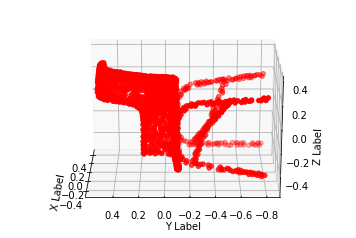

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# need to do it twice to have the plot correctly
def get_pts(data):
    return data[12:,0], data[12:,1], data[12:,2] #returns X,Y,Z points skipping the first 12 lines

def plot_ply(infile):
     
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
 
    ax.view_init(20, 180)

    x,y,z = get_pts(infile)
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show
    #plt.draw()
    #plt.pause(.001)


print("This is a ", batch_labels[25])
plot_ply(batch_points_ls[25])


This is a  toilet


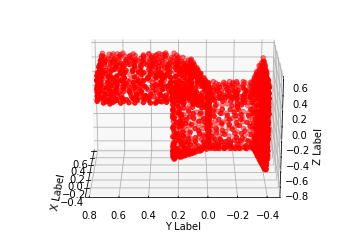

In [18]:
print("This is a ", batch_labels[3])
plot_ply(batch_points_ls[3])

This is a  lamp


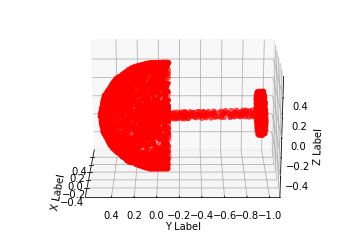

In [19]:
print("This is a ", batch_labels[193])
plot_ply(batch_points_ls[193])